# Week 4A: Geospatial Data Analysis, Continued

- Section 401
- Monday, September 25, 2023

## Housekeeping

- [Homework #1](https://github.com/MUSA-550-Fall-2023/assignment-1) due today by the end of the day
- [Homework #2](https://github.com/MUSA-550-Fall-2023/assignment-2) assigned, due in two weeks
- Choose a dataset to visualize and explore
    - [OpenDataPhilly](https://opendataphilly.org) or one your choosing
    - Email me if you want to analyze one that's not on OpenDataPhilly

## Agenda for Week #4

**Last lecture**
- Vector data and introduction to GeoPandas
- Spatial relationships
- Spatial joins

**Today**

- Visualization for geospatial data
- Demo: 311 requests by neighborhood in Philadelphia
- Exercise: Property assessments by neighborhood

In [1]:
# Let's setup the imports we'll need first
import altair as alt
import geopandas as gpd
import hvplot.pandas
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

## Example, Continued: Exploring trash-related 311 tickets by neighborhood in 2020

Let's continuing analyzing data for 311 requests in Philadelphia during the pandemic in 2020. Today, we'll dive into examining trends by neighborhood.


::: {.callout-tip title="Find out more..."}

Trash collection was a big concern in Philadelphia when the pandemic began.
Check out [this article](https://www.inquirer.com/news/philadephia-trash-recycling-collection-delays-covid-20200806.html) in the Philadelphia Inquirer for more details!

:::


First, let's load our data and create our GeoDataFrame. 

**Note:** The below code is copied over from last lecture (lecture 3B).

In [3]:
# Load the data from a CSV file into a pandas DataFrame
trash_requests_df = pd.read_csv(
    "data/trash_311_requests_2020.csv",  # Use the file path relative to the current folder
)

# Remove rows with missing geometry
trash_requests_df = trash_requests_df.dropna(subset=["lat", "lon"])

# Create our GeoDataFrame with geometry column created from lon/lat
trash_requests = gpd.GeoDataFrame(
    trash_requests_df,
    geometry=gpd.points_from_xy(trash_requests_df["lon"], trash_requests_df["lat"]),
    crs="EPSG:4326",
)

Now let's examine the trends by neighborhoods across the city.

**Goal:** For each neighborhood, calculate the number of trash-related requests

### 1. Load Zillow neighborhood data

A GeoJSON holding Zillow definitions for Philadelphia neighborhoods is available in the `data/` directory. 

In [4]:
zillow = gpd.read_file("data/zillow_neighborhoods.geojson")

In [5]:
zillow.head()

,ZillowName,geometry
0,Academy Gardens,"POLYGON ((-74.99851 40.06435, -74.99456 40.061..."
1,Airport,"POLYGON ((-75.19728 39.89252, -75.19617 39.892..."
2,Allegheny West,"POLYGON ((-75.16592 40.00327, -75.16596 40.003..."
3,Andorra,"POLYGON ((-75.22463 40.06686, -75.22588 40.065..."
4,Aston Woodbridge,"POLYGON ((-75.00860 40.05369, -75.00861 40.053..."


Convert to a better CRS (EPSG:3857) and make a quick plot:

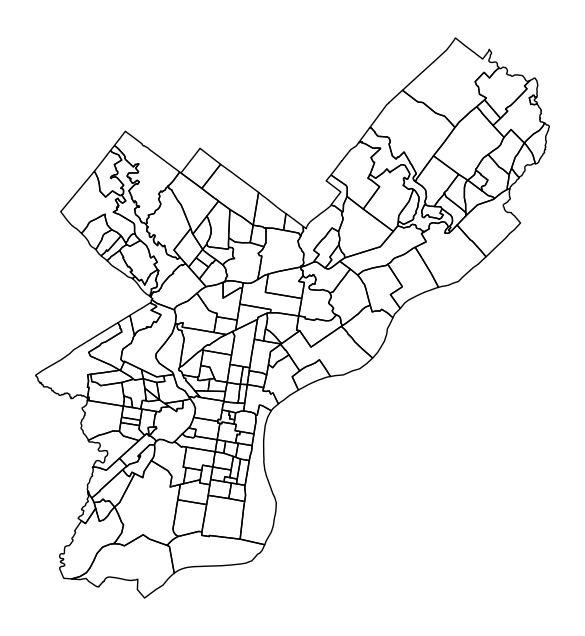

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))

ax = zillow.to_crs(epsg=3857).plot(ax=ax, facecolor="none", edgecolor="black")

ax.set_axis_off()
ax.set_aspect("equal")

### 2. Do a spatial join between requests and neighborhoods

Use the `sjoin()` function to match point data (requests) to polygon data (neighborhoods) based on which neighborhood each request location is within.


::: {.callout-important}
Make sure the two GeoDataFrames are in the same CRS when calculating a spatial join! If not, geopandas will print out a warning.
:::

In [7]:
requests_with_hood = gpd.sjoin(
    trash_requests,  # The point data for 311 tickets
    zillow.to_crs(trash_requests.crs),  # The neighborhoods (in the same CRS)
    predicate="within",
    how="left",
)

In [8]:
requests_with_hood.head()

,objectid,service_request_id,status,status_notes,service_name,service_code,agency_responsible,service_notice,requested_datetime,updated_datetime,expected_datetime,address,zipcode,media_url,lat,lon,geometry,index_right,ZillowName
0,8180042,13269656,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-04-02 19:22:24,2020-04-06 07:02:57,2020-04-06 20:00:00,624 FOULKROD ST,NaN,NaN,40.034389,-75.106518,POINT (-75.10652 40.03439),70.0,Lawndale
1,8180043,13266979,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-04-02 08:40:53,2020-04-06 07:02:58,2020-04-05 20:00:00,1203 ELLSWORTH ST,NaN,NaN,39.936164,-75.163497,POINT (-75.16350 39.93616),105.0,Passyunk Square
2,7744426,13066443,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-01-02 19:17:55,2020-01-04 05:46:06,2020-01-06 19:00:00,9054 WESLEYAN RD,NaN,NaN,40.058737,-75.018345,POINT (-75.01835 40.05874),109.0,Pennypack Woods
3,7744427,13066540,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-01-03 07:01:46,2020-01-04 05:46:07,2020-01-06 19:00:00,2784 WILLITS RD,NaN,NaN,40.063658,-75.022347,POINT (-75.02235 40.06366),107.0,Pennypack
4,7801094,13089345,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-01-15 13:22:14,2020-01-16 14:03:29,2020-01-16 19:00:00,6137 LOCUST ST,NaN,NaN,39.958186,-75.244732,POINT (-75.24473 39.95819),21.0,Cobbs Creek


### 3. Group by neighborhood and calculate the size

In [9]:
totals = requests_with_hood.groupby("ZillowName", as_index=False).size()


**Note:** we're once again using the `as_index=False` to ensure the result of the `.size()` function is a DataFrame rather than a Series with the `ZillowName` as its index

In [10]:
totals.head()

,ZillowName,size
0,Academy Gardens,84
1,Allegheny West,330
2,Andorra,83
3,Aston Woodbridge,110
4,Bartram Village,35


### 4. Merge our geometries back in

Lastly, merge Zillow geometries (GeoDataFrame) with the total # of requests per neighborhood (DataFrame).

::: {.callout-important}

When merging a GeoDataFrame (spatial) and DataFrame (non-spatial), you should always call the `.merge()` function of the spatial data set to ensure that the merged data is a GeoDataFrame. 

:::

For example...

In [11]:
# Do GeoDataFrame.merge(DataFrame) here...
requests_by_hood = zillow.merge(totals, on="ZillowName")

In [11]:
requests_by_hood.head()

,ZillowName,geometry,size
0,Academy Gardens,"POLYGON ((-74.99851 40.06435, -74.99456 40.061...",84
1,Allegheny West,"POLYGON ((-75.16592 40.00327, -75.16596 40.003...",330
2,Andorra,"POLYGON ((-75.22463 40.06686, -75.22588 40.065...",83
3,Aston Woodbridge,"POLYGON ((-75.00860 40.05369, -75.00861 40.053...",110
4,Bartram Village,"POLYGON ((-75.20733 39.93350, -75.20733 39.933...",35


## Data viz example: Choropleth maps

Choropleth maps color polygon regions according to the values of a specific data attribute. In this section, we'll explore a number of different ways to plot them in Python.

### Static via the geopandas `plot()` function

Choropleth maps are *built-in* to GeoDataFrame objects via the `plot()` function. Let's use the "size" column to plot the total number of requests per neighborhood:

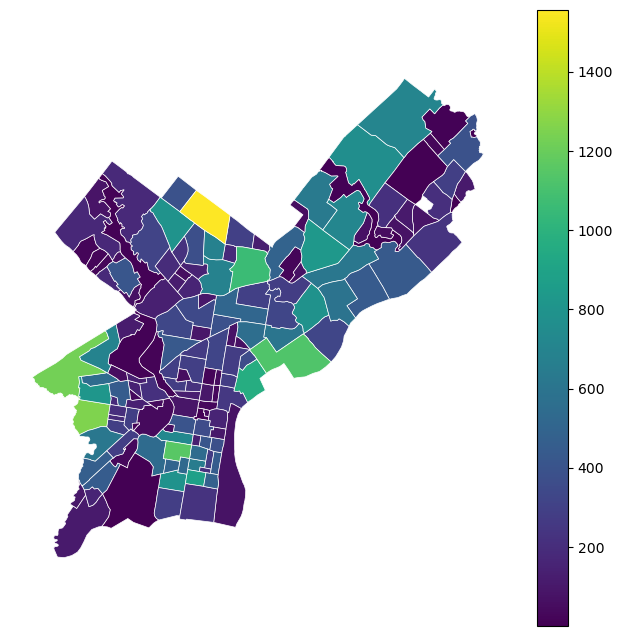

In [12]:
# Create the figure/axes
fig, ax = plt.subplots(figsize=(8, 8))

# Plot
requests_by_hood.to_crs(epsg=3857).plot(
    ax=ax,
    column="size",  # NEW: Specify the column to color polygons by
    edgecolor="white",
    linewidth=0.5,
    legend=True,
    cmap="viridis",
)

# Format
ax.set_axis_off()
ax.set_aspect("equal")

#### 1. Improving the aesthetics

Two optional but helpful improvements:
- Make the colorbar line up with the axes. The default configuration will always overshoot the axes.
- Explicitly set the limits of the x-axis and y-axis to zoom in and center the map

In [13]:
# Needed to line up the colorbar properly
from mpl_toolkits.axes_grid1 import make_axes_locatable

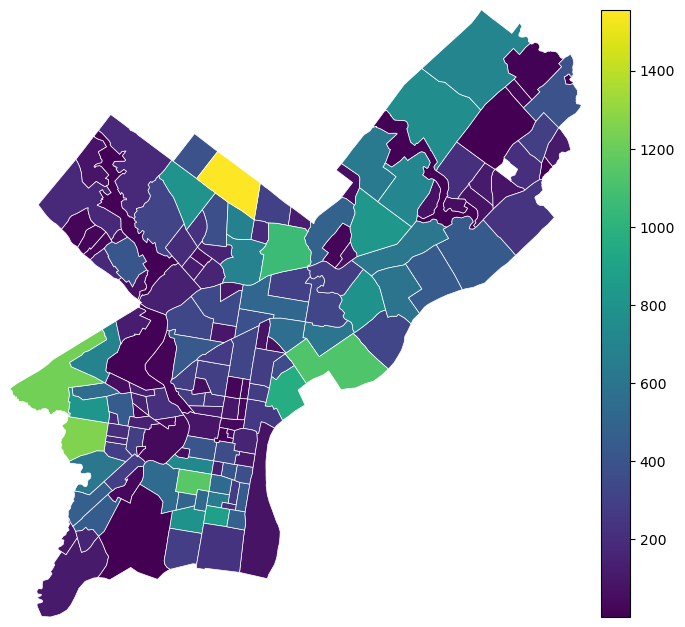

In [14]:
# Create the figure
fig, ax = plt.subplots(figsize=(8, 8))

# NEW: Create a nice, lined up colorbar axes (called "cax" here)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

# Plot
requests_by_hood.to_crs(epsg=3857).plot(
    ax=ax,
    cax=cax,  # NEW
    column="size",
    edgecolor="white",
    linewidth=0.5,
    legend=True,
    cmap="viridis",
)

# NEW: Get the limits of the GeoDataFrame
xmin, ymin, xmax, ymax = requests_by_hood.to_crs(epsg=3857).total_bounds

# NEW: Set the xlims and ylims
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Format
ax.set_axis_off()
ax.set_aspect("equal")

*These improvements are optional, but they definitely make for nicer plots!*

#### 2. Improving the data

**Problem:** The variation in the sizes of neighborhoods across the city makes it hard to compare raw counts in a choropleth map.

Better to normalize by area: **use the .area attribute of the geometry series**

In [13]:
requests_by_hood_3857 = requests_by_hood.to_crs(epsg=3857)

requests_by_hood_3857["N_per_area"] = (
    requests_by_hood_3857["size"] / (requests_by_hood_3857.geometry.area) * 1e4
)

Now plot the normalized totals:

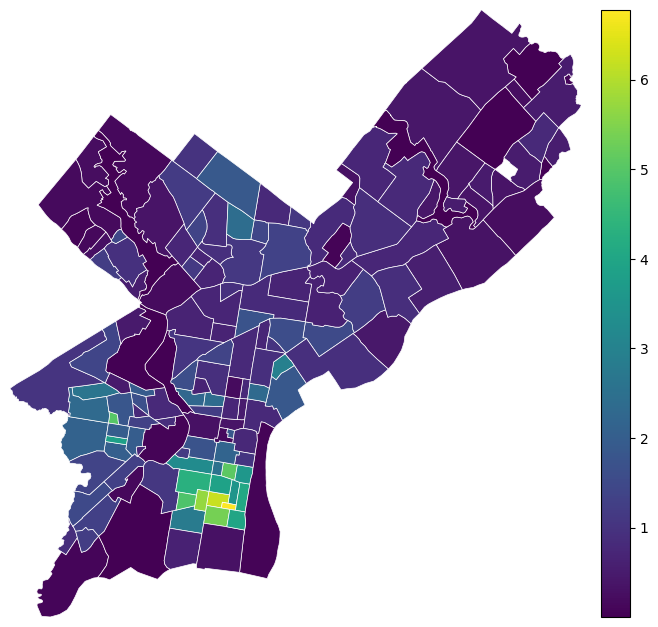

In [16]:
# Create the figure
fig, ax = plt.subplots(figsize=(8, 8))

# Create a nice, lined up colorbar axes (called "cax" here)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

# Plot
requests_by_hood_3857.plot(
    ax=ax,
    cax=cax,
    column="N_per_area",  # NEW: Use the normalized column
    edgecolor="white",
    linewidth=0.5,
    legend=True,
    cmap="viridis",
)

# Get the limits of the GeoDataFrame
xmin, ymin, xmax, ymax = requests_by_hood_3857.total_bounds

# Set the xlims and ylims
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Format
ax.set_axis_off()
ax.set_aspect("equal")

**Even better...**

Since households are driving the 311 requests, it would be even better to normalize by the number of properties in a given neighborhood rather than neighborhood area.

#### 3. Improving the color mapping


By default, geopandas just maps the data to a continuous color bar. Sometimes, it is helpful to instead classify the data into bins and visualize the separate bins. This can help highlight trends not immediately clear when using a continuous color mapping. 

Classification via bins is built-in to the `plot()` function! Many different schemes, but here are some of the most common ones:

1. **Quantiles:** assigns the same number of data points per bin
1. **EqualInterval:** divides the *range of the data* into equally sized bins
1. **FisherJenks:** [scheme](https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization) that tries to minimize the variance within each bin and maximize the variances between different bins.

Trying out multiple classification schemes can help you figure out trends more easily during your exploratory analysis!

1. **Quantiles Scheme:** assigns the same number of data points per bin

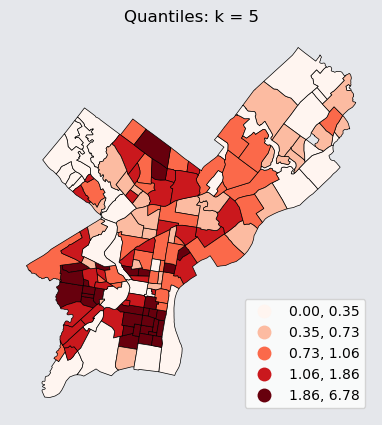

In [15]:
# Initialize figure and axes
fig, ax = plt.subplots(figsize=(8, 5), facecolor="#e5e7eb")

# Plot
requests_by_hood_3857.plot(
    ax=ax,
    column="N_per_area",  # NEW: Specify the column to color polygons by
    edgecolor="black",
    linewidth=0.5,
    legend_kwds=dict(loc="lower right", fontsize=10),
    legend=True,
    cmap="Reds",
    scheme="Quantiles",
    k=5,
)

# Format
ax.set_title("Quantiles: k = 5")
ax.set_axis_off()
ax.set_aspect("equal")

2. **Equal Interval Scheme:** divides the *range of the data* into equally sized bins

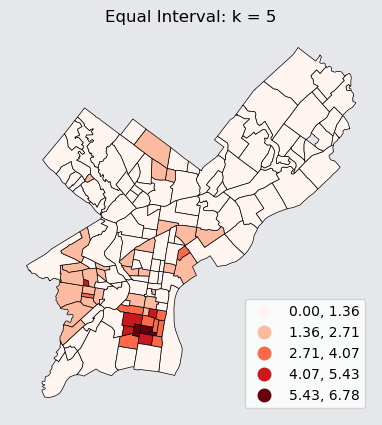

In [16]:
# Initialize figure and axes
fig, ax = plt.subplots(figsize=(8, 5), facecolor="#e5e7eb")

# Plot
requests_by_hood_3857.plot(
    ax=ax,
    column="N_per_area",
    edgecolor="black",
    linewidth=0.5,
    legend=True,
    legend_kwds=dict(loc="lower right", fontsize=10),
    cmap="Reds",
    scheme="EqualInterval",
    k=5,
)

# Format
ax.set_title("Equal Interval: k = 5")
ax.set_axis_off()
ax.set_aspect("equal")

3. **Fisher Jenks Scheme**: minimize the variance within each bin and maximize the variances between different bins.

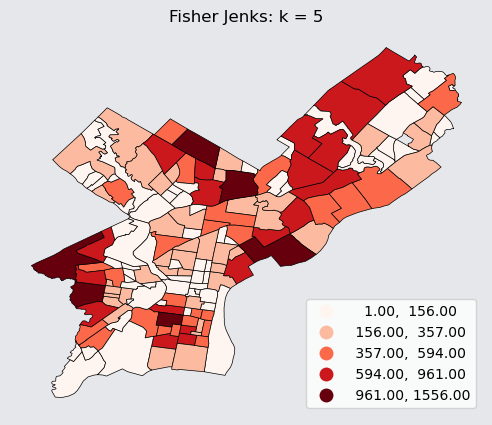

In [17]:
# Initialize figure and axes
fig, ax = plt.subplots(figsize=(8, 5), facecolor="#e5e7eb")

# Plot
requests_by_hood.plot(
    ax=ax,
    column="size",
    edgecolor="black",
    linewidth=0.5,
    legend=True,
    legend_kwds=dict(loc="lower right", fontsize=10),
    cmap="Reds",
    scheme="FisherJenks",
)

# Format
ax.set_title("Fisher Jenks: k = 5")
ax.set_axis_off()
ax.set_aspect("equal")

::: {.callout-tip}

Geopandas relies on an external package called `mapclassify` for the classification schemes. 
The documentation can be found here: https://pysal.org/mapclassify/api.html

It contains the full list of schemes and the function definitions for each.
:::

### Interactive via altair

Altair charts accept `GeoDataFrames` as data and altair includes a "geoshape" mark, so choropleths are easy to make.


::: {.callout-important title="Altair and projections"}

Altair's support for different projections isn't the best. The recommended strategy is to convert your data to the desired CRS (e.g., EPSG:3857 or the local state plane projection (EPSG:2272 for Philadelphia)) and then tell altair not to project your data by including the following:

```python
chart.project(type="identity", reflectY=True)
```

:::

In [42]:
(
    alt.Chart(requests_by_hood_3857)
    .mark_geoshape(stroke="white")
    .encode(
        tooltip=["N_per_area:Q", "ZillowName:N", "size:Q"],
        color=alt.Color("N_per_area:Q", scale=alt.Scale(scheme="viridis")),
    )
    # Important! Otherwise altair will try to re-project your data
    .project(type="identity", reflectY=True)
    .properties(width=500, height=500)
)

alt.Chart(...)

### Interactive via hvplot

We can use the built-in `.hvplot()` function to plot interactive choropleth maps!


::: {.callout-important title="Hvplot and projections"}

There are two relevant keywords related to projections and coordinate reference systems. Since we are plotting geospatial data, you will need to specify the `geo=True` keyword. If your data is in EPSG:4326, you are all set and that's all you need to do. If your data is NOT in EPSG:4326, you will need to specify the `crs=` keyword and pass the EPSG code to hvplot. 

In the example below, our data is in EPSG:3857 and we specify that via the `crs` keyword.


:::

In [18]:
requests_by_hood.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
# Pass arguments directly to hvplot()
# and it recognizes polygons automatically
requests_by_hood_3857.hvplot(
    c="N_per_area",
    frame_width=600,
    frame_height=600,
    geo=True,
    crs=3857,
    cmap="viridis",
    hover_cols=["ZillowName"],
)

:Polygons   [Longitude,Latitude]   (N_per_area,ZillowName)

#### Adding in tile maps underneath with geoviews

hvplot can leverage the power of [geoviews](https://geoviews.org/index.html), the geographic equivalent of holoviews, to add in base tile maps underneath our choropleth map.

Let's try it out:

In [20]:
import geoviews as gv
import geoviews.tile_sources as gvts

In [21]:
type(gvts.EsriImagery)

geoviews.element.geo.WMTS

In [22]:
%%opts WMTS [width=800, height=800, xaxis=None, yaxis=None]

choro = requests_by_hood.hvplot(
    c="N_per_area",
    frame_width=600,
    frame_height=600,
    alpha=0.5,
    geo=True,
    crs=3857,
    cmap="viridis",
    hover_cols=["ZillowName"],
)

gvts.EsriImagery * choro

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (ZillowName)

::: {.callout-warning}

For the moment, you'll need to have your overlaid polygons in Web Mercator, EPSG:3857. There's a bug in geoviews that is preventing the underlying raster data from showing properly when combined with data that is using a different CRS.

:::

#### Many of the most common tile sources are available..

*Stay tuned:* More on this next week when we talk about raster data!

In [23]:
%%opts WMTS [width=200, height=200, xaxis=None, yaxis=None]

(
    gvts.OSM
    + gvts.StamenToner
    + gvts.EsriNatGeo
    + gvts.EsriImagery
    + gvts.EsriUSATopo
    + gvts.EsriTerrain
    + gvts.CartoDark
    + gvts.CartoLight
).cols(4)

:Layout
   .WMTS.I    :WMTS   [Longitude,Latitude]
   .WMTS.II   :WMTS   [Longitude,Latitude]
   .WMTS.III  :WMTS   [Longitude,Latitude]
   .WMTS.IV   :WMTS   [Longitude,Latitude]
   .WMTS.V    :WMTS   [Longitude,Latitude]
   .WMTS.VI   :WMTS   [Longitude,Latitude]
   .WMTS.VII  :WMTS   [Longitude,Latitude]
   .WMTS.VIII :WMTS   [Longitude,Latitude]

::: {.callout-note}

We've used the `%%opts` cell magic to apply syling options to any charts generated in the cell.

See [the documentation guide on customizations](http://holoviews.org/user_guide/Notebook_Magics.html) for more details.

:::

### Interactive via the geopandas `.explore()` function

Geopandas recently introduced the ability to produce interactive choropleth maps via the `.explore()` function. It leverages the [Folium](https://python-visualization.github.io/folium/latest/) package to produce an interactive web map. 

**Stay tuned:** We'll discuss interactive web maps and the Folium package in much more detail next week!

In [25]:
requests_by_hood.explore(
    column="N_per_area",  # Similar to plot(); specify the value column
    cmap="viridis",  # What color map do we want to use
    tiles="CartoDB positron",  # What basemap tiles do we want to use?
)

KeyError: 'N_per_area'

::: {.callout-tip}

Check out the documentation for `.explore()` via the `?` operator for details on what kind of tiles are available as well as other options.

For more information, see the [Geopandas documentation on interactive mapping](https://geopandas.org/en/stable/docs/user_guide/interactive_mapping.html).
:::

## Data viz example: Hex bins

Another great way to visualize geospatial data is via hex bins, where hexagonal bins aggregate quantities over small spatial regions. Let's try out a couple different ways of visualizing our data this way.

::: {.callout-note}

When visualizing data with hex bins, we will pass the full dataset (before any aggregations) to the plotting function, which will handle aggregating the data into hexagonal bins and visualizing it.


### Optional aggregations
By default, the function will just count the number of points that fall into each hexagonal bin. Optionally, we can also specify a column to aggregate in each bin, and a corresponding function to use to do the aggregation (e.g., the sum or median function). These are specified as:

- An optional `C` column to aggregate for each bin (raw counts are shown if not provided)
- A `reduce_C_function` that determines how to aggregate the `C` column

:::

### Static via matplotlib

Let's try out matplotlib's `hexbin()` function ([docs](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hexbin.html)), and overlay the Zillow neighborhood boundaries on top!

In [31]:
plt.hexbin?

Signature:
plt.hexbin(
    x,
    y,
    C=None,
    gridsize=100,
    bins=None,
    xscale='linear',
    yscale='linear',
    extent=None,
    cmap=None,
    norm=None,
    vmin=None,
    vmax=None,
    alpha=None,
    linewidths=None,
    edgecolors='face',
    reduce_C_function=<function mean at 0x10b51edd0>,
    mincnt=None,
    marginals=False,
    *,
    data=None,
    **kwargs,
)
Docstring:
Make a 2D hexagonal binning plot of points *x*, *y*.

If *C* is *None*, the value of the hexagon is determined by the number
of points in the hexagon. Otherwise, *C* specifies values at the
coordinate (x[i], y[i]). For each hexagon, these values are reduced
using *reduce_C_function*.

Parameters
----------
x, y : array-like
    The data positions. *x* and *y* must be of the same length.

C : array-like, optional
    If given, these values are accumulated in the bins. Otherwise,
    every point has a value of 1. Must be of the same length as *x*
    and *y*.

gridsize : int or (int, int), def

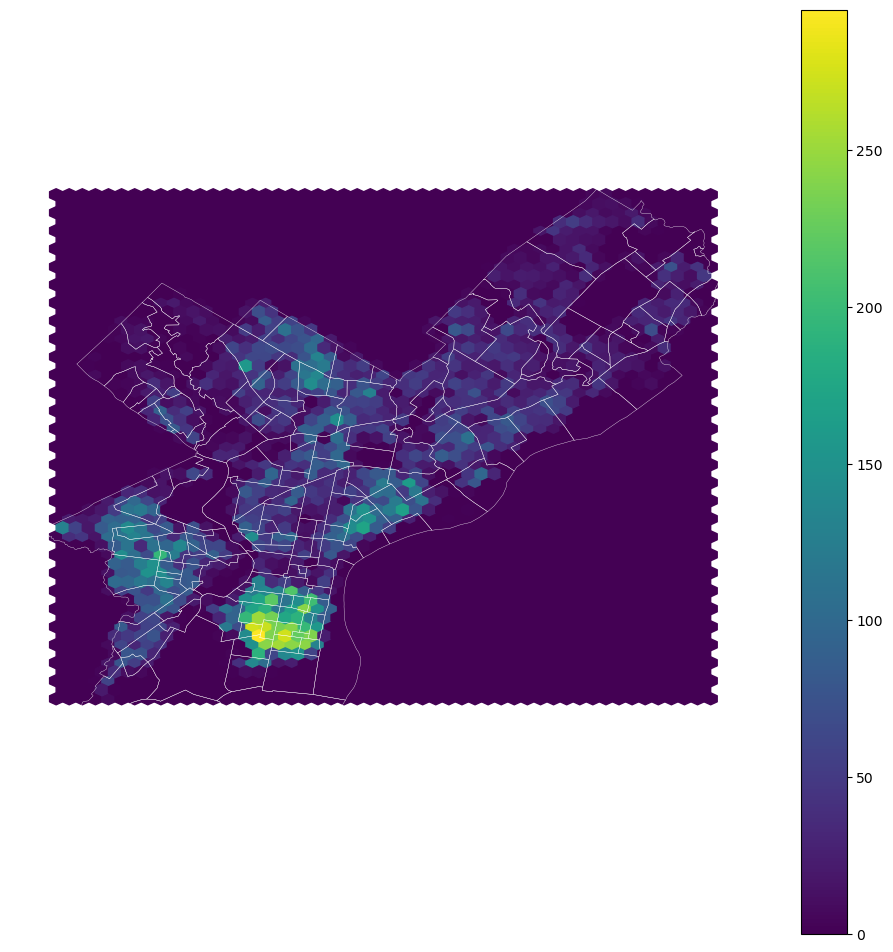

In [26]:
# Create the axes
fig, ax = plt.subplots(figsize=(12, 12))

# Extract out the x/y coordindates of the Point objects
xcoords = trash_requests.geometry.x
ycoords = trash_requests.geometry.y

# Plot a hexbin chart
# NOTE: We are passing the full set of coordinates to matplotlib — we haven't done any aggregations
hex_vals = ax.hexbin(xcoords, ycoords, gridsize=50)

# Add the zillow geometry boundaries
zillow.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=0.25)

# Add a colorbar and format
fig.colorbar(hex_vals, ax=ax)
ax.set_axis_off()
ax.set_aspect("equal")

*Great!* This looks very close to the `N_per_area` choropleth chart we made previously. It definitely shows a similar concentration of tickets in South Philly.

### Interactive via hvplot

Hvplot also has an interactive hex bin function...let's try it out!

**Remember:** once again, we'll be using the original (un-aggregated) data frame.

#### Step 1: Extract out the x/y values of the data 

- Let's add them as new columns into the data frame
- Remember, you can the use "x" and "y" attributes of the "geometry" column.

In [33]:
trash_requests["x"] = trash_requests.geometry.x
trash_requests["y"] = trash_requests.geometry.y

In [34]:
trash_requests.head()

,objectid,service_request_id,status,status_notes,service_name,service_code,agency_responsible,service_notice,requested_datetime,updated_datetime,expected_datetime,address,zipcode,media_url,lat,lon,geometry,x,y
0,8180042,13269656,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-04-02 19:22:24,2020-04-06 07:02:57,2020-04-06 20:00:00,624 FOULKROD ST,NaN,NaN,40.034389,-75.106518,POINT (-8360819.322 4870940.907),-8.360819e+06,4.870941e+06
1,8180043,13266979,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-04-02 08:40:53,2020-04-06 07:02:58,2020-04-05 20:00:00,1203 ELLSWORTH ST,NaN,NaN,39.936164,-75.163497,POINT (-8367162.212 4856670.199),-8.367162e+06,4.856670e+06
2,7744426,13066443,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-01-02 19:17:55,2020-01-04 05:46:06,2020-01-06 19:00:00,9054 WESLEYAN RD,NaN,NaN,40.058737,-75.018345,POINT (-8351004.015 4874481.442),-8.351004e+06,4.874481e+06
3,7744427,13066540,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-01-03 07:01:46,2020-01-04 05:46:07,2020-01-06 19:00:00,2784 WILLITS RD,NaN,NaN,40.063658,-75.022347,POINT (-8351449.489 4875197.202),-8.351449e+06,4.875197e+06
4,7801094,13089345,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-01-15 13:22:14,2020-01-16 14:03:29,2020-01-16 19:00:00,6137 LOCUST ST,NaN,NaN,39.958186,-75.244732,POINT (-8376205.240 4859867.796),-8.376205e+06,4.859868e+06


#### Step 2: Plot with the hexbin function

- Similar syntax to matplotlib's hexbin() function
- Specify:
    - The x/y coordinates, 
    - An optional `C` column to aggregate for each bin (raw counts are shown if not provided)
    - A `reduce_function` that determines how to aggregate the `C` column

In [35]:
trash_requests.hvplot.hexbin?

Signature:
trash_requests.hvplot.hexbin(
    x=None,
    y=None,
    C=None,
    colorbar=True,
    *,
    alpha,
    cmap,
    color,
    fill_alpha,
    fill_color,
    hover_alpha,
    hover_color,
    hover_fill_alpha,
    hover_fill_color,
    hover_line_alpha,
    hover_line_cap,
    hover_line_color,
    hover_line_dash,
    hover_line_join,
    hover_line_width,
    line_alpha,
    line_cap,
    line_color,
    line_dash,
    line_join,
    line_width,
    muted,
    muted_alpha,
    muted_color,
    muted_fill_alpha,
    muted_fill_color,
    muted_line_alpha,
    muted_line_cap,
    muted_line_color,
    muted_line_dash,
    muted_line_join,
    muted_line_width,
    nonselection_alpha,
    nonselection_color,
    nonselection_fill_alpha,
    nonselection_fill_color,
    nonselection_line_alpha,
    nonselection_line_cap,
    nonselection_line_color,
    nonselection_line_dash,
    nonselection_line_join,
    nonselection_line_width,
    scale,
    selection_alpha,
    select

In [36]:
trash_requests.head()

,objectid,service_request_id,status,status_notes,service_name,service_code,agency_responsible,service_notice,requested_datetime,updated_datetime,expected_datetime,address,zipcode,media_url,lat,lon,geometry,x,y
0,8180042,13269656,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-04-02 19:22:24,2020-04-06 07:02:57,2020-04-06 20:00:00,624 FOULKROD ST,NaN,NaN,40.034389,-75.106518,POINT (-8360819.322 4870940.907),-8.360819e+06,4.870941e+06
1,8180043,13266979,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-04-02 08:40:53,2020-04-06 07:02:58,2020-04-05 20:00:00,1203 ELLSWORTH ST,NaN,NaN,39.936164,-75.163497,POINT (-8367162.212 4856670.199),-8.367162e+06,4.856670e+06
2,7744426,13066443,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-01-02 19:17:55,2020-01-04 05:46:06,2020-01-06 19:00:00,9054 WESLEYAN RD,NaN,NaN,40.058737,-75.018345,POINT (-8351004.015 4874481.442),-8.351004e+06,4.874481e+06
3,7744427,13066540,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-01-03 07:01:46,2020-01-04 05:46:07,2020-01-06 19:00:00,2784 WILLITS RD,NaN,NaN,40.063658,-75.022347,POINT (-8351449.489 4875197.202),-8.351449e+06,4.875197e+06
4,7801094,13089345,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-01-15 13:22:14,2020-01-16 14:03:29,2020-01-16 19:00:00,6137 LOCUST ST,NaN,NaN,39.958186,-75.244732,POINT (-8376205.240 4859867.796),-8.376205e+06,4.859868e+06


In [37]:
hexbins = trash_requests.hvplot.hexbin(
    x="x",
    y="y",
    geo=True,
    crs=3857,
    gridsize=40,  # The number of cells in the x/y directions
    alpha=0.5,
    cmap="viridis",
    frame_width=600,
    frame_height=600,
)

# Add the imagery underneath
gvts.EsriImagery * hexbins

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .HexTiles.I :HexTiles   [x,y]

### Which viz method is best?

We've seen a lot of different options for visualizing geospatial data so far. So, which was is best? 

...It depends.

**A few guiding principles:**
- If you're looking to share the visualization with others, static is probably the better choice
- If you're doing an exploratory analysis, generally an interactive map will be more helpful for understanding trends
- For exploratory, interactive analysis, ease of use is key — for this reason, I usually tend to use `.hvplot()` or `.explore()` rather than altair, which doesn't add base tiles to the chart and is a bit more limited in its functionality



::: {.callout-note}
More on interactive web maps next week when we discuss Folium in more detail!
:::

## Exercise: property assessments in Philadelphia

**Goals**: 
Visualize the property assessment values by neighborhood in Philadelphia, using *one or more* of the following:

- Static choropleth map via geopandas
- Interactive choropleth map via geopandas / altair / hvplot
- Static hex bin map via matplotlib
- Interactive hex bin map via hvplot


### The dataset

- Property assessment data from [OpenDataPhilly](https://www.opendataphilly.org/dataset/opa-property-assessments)
- Available in the `data/` folder
- Residential properties only — over 460,000 properties 

### Step 1: Load the assessment data

In [2]:
data = pd.read_csv("./data/opa_residential.csv")
data.head()

,parcel_number,lat,lng,location,market_value,building_value,land_value,total_land_area,total_livable_area
0,71361800,39.991575,-75.128994,2726 A ST,62200.0,44473.0,17727.0,1109.69,1638.0
1,71362100,39.991702,-75.128978,2732 A ST,25200.0,18018.0,7182.0,1109.69,1638.0
2,71362200,39.991744,-75.128971,2734 A ST,62200.0,44473.0,17727.0,1109.69,1638.0
3,71362600,39.991994,-75.128895,2742 A ST,15500.0,11083.0,4417.0,1109.69,1638.0
4,71363800,39.992592,-75.128743,2814 A ST,31300.0,22400.0,8900.0,643.50,890.0


We'll focus on the `market_value` column for this analysis

### Step 2: Convert to a GeoDataFrame

Remember to set the EPSG of the input data — this data is in the typical lat/lng coordinates (EPSG=4326)

In [3]:
# Remove rows with missing geometry
data = data.dropna(subset=["lat", "lng"])

# Create our GeoDataFrame with geometry column created from lon/lat
geodata = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data["lng"], data["lat"]),
    crs="EPSG:4326",
)

geodata = geodata.to_crs(epsg=3857)
print(type(geodata))

<class 'geopandas.geodataframe.GeoDataFrame'>


### Step 3: Do a spatial join with Zillow neighbohoods

Use the `sjoin()` function. 

Make sure you CRS's match before doing the sjoin!

In [5]:
zillow = gpd.read_file('.\data\zillow_neighborhoods.geojson').to_crs(epsg=3857)

join_data = gpd.sjoin(geodata,zillow,predicate='within',how='left')

### Step 4: Make a choropleth of the median market value by neighborhood

Use the built-in `.plot()` function to make a static version, or `.explore()` to make an interactive version. 

::: {.callout-tip title="Hints"}
- You will need to group by Zillow neighborhood
- Calculate the median market value per neighborhood
- Join with the Zillow neighborhood GeoDataFrame
:::

In [6]:
median_data = join_data.groupby('ZillowName')['market_value'].median()

zillow_joined = zillow.merge(median_data, on=['ZillowName'])


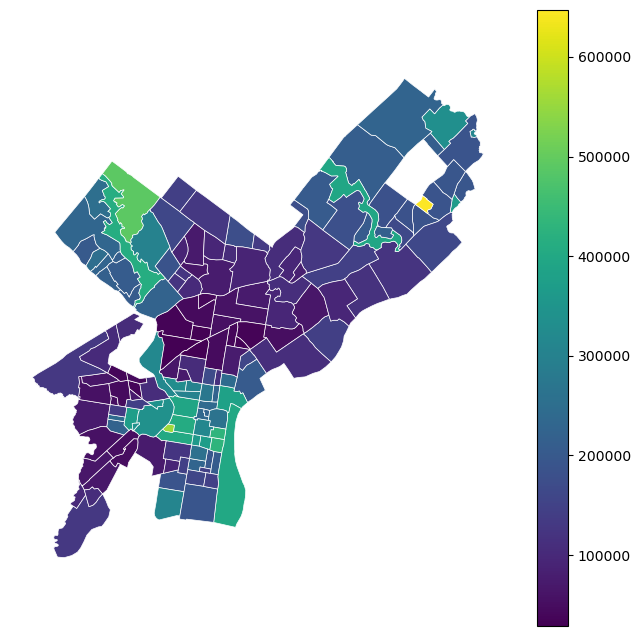

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot
zillow_joined.plot(
    ax=ax,
    column="market_value",  # NEW: Specify the column to color polygons by
    edgecolor="white",
    linewidth=0.5,
    legend=True,
    cmap="viridis"
)

# Format
ax.set_axis_off()
ax.set_aspect("equal")

In [11]:
zillow_joined.explore(column="market_value")

### Step 5: Make a hex bin map of median assessments

Make a static version with matplotlib or an interactive version with hvplot.

**Remember,** you will need to pass in the original, un-aggregated data to the plotting function!

::: {.callout-tip title="Hints"}

For matplotlib's `hexbin()` function:
- You will need to use the `C` and `reduce_C_function` of the `hexbin()` function
- Run `plt.hexbin?` for more help
- Try testing the impact of setting `bins='log'` on the resulting map

For hvplot's `hexbin()` function:
- You will need to use the `C` and `reduce_function` of the `hexbin()` function
- Run `df.hvplot.hexbin?` for more help
- Try testing the impact of setting `logz=True` on the resulting map


:::

**Note:** you should pass in the raw point data rather than any aggregated data to the `hexbin()` function

In [8]:
geodata.hvplot.hexbin(x='lng',
                   y='lat', 
                   C='market_value',
                   reduce_function='median',
                   gridsize=40,  # The number of cells in the x/y directions
                   cmap="viridis",
                   frame_width=600,
                   frame_height=600)

DataError: None of the available storage backends were able to support the supplied data format.

:HexTiles   [lng,lat]   (market_value)

## That's it!

- More interactive web maps and raster datasets next week!
- See you next Monday!